# Business Cycle - Bonds

## Imports

In [20]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [21]:
frequency = 1
t_cost = 0
target_vol = 0.10
min_regions = 4
lag_months = 3

## Data

### Riskfree Data

In [22]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
riskfree

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_29210/2677495952.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [23]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_29210/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [24]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Macro Data

In [25]:
# --- Load Macro Data ---
rgdp_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'RGDP',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

cpi_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'CPI',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

# --- Align and Forward-Fill RGDP Data ---

# Get the monthly index from the CPI data
monthly_index = cpi_data.index

# Reindex the quarterly RGDP data to the monthly frequency.
# This introduces NaN values for the months that are not the start of a quarter.
rgdp_monthly = rgdp_data.reindex(monthly_index)

# Forward-fill (ffill) the NaN values.
# This carries the quarterly value forward to the subsequent two months.
rgdp_ffilled = rgdp_monthly.ffill()

rgdp_ffilled.index = rgdp_ffilled.index + pd.offsets.MonthEnd(0)

# Adjust the CPI DataFrame index to month-end
cpi_data.index = cpi_data.index + pd.offsets.MonthEnd(0)

# --- Final DataFrames ---
rgdp_final = rgdp_ffilled
cpi_final = cpi_data

display(rgdp_final)
display(cpi_final)

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-02-28,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-03-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-04-30,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
1970-05-31,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-08-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-09-30,3.500000,2.1,1.3,0.5,1.1,1.4,4.8


,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,6.162465,NaN,4.9,2.3,NaN,NaN,NaN
1970-02-28,6.424581,NaN,4.9,2.1,NaN,NaN,NaN
1970-03-31,6.094183,2.1,5.0,2.5,NaN,NaN,NaN
1970-04-30,6.060606,2.1,5.4,2.6,NaN,NaN,NaN
1970-05-31,6.043956,2.1,5.7,3.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,2.731801,2.1,3.8,0.2,3.1,2.0,0.0
2025-08-31,2.939220,2.1,3.8,0.2,2.7,2.0,-0.4
2025-09-30,3.022700,3.2,3.8,0.2,2.9,2.2,-0.3


### Bond Data

In [26]:
# --- Load Bond Futures ---
bond_futures = pd.read_excel(
    f"{path}/Bond Futures.xlsx",
    index_col = 0,
    parse_dates = True
)
bond_futures.index = pd.to_datetime(bond_futures.index)
bond_futures.index = bond_futures.index + pd.offsets.MonthEnd(0)

bond_futures

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,72.58774,89.88,83.91110,58.968750,90.12,NaN,89.28422
1998-02-28,73.84924,90.45,83.86650,58.437500,91.37,NaN,89.20823
1998-03-31,72.76451,90.75,84.08059,58.281250,90.54,NaN,92.70965
1998-04-30,74.66254,91.56,83.99135,58.250000,89.35,NaN,92.89550
1998-05-31,75.80680,93.14,84.46878,58.593750,91.27,NaN,91.67311
...,...,...,...,...,...,...,...
2025-07-31,147.00613,137.03,61.55103,111.078125,196.99,15.03735,121.79588
2025-08-31,150.42250,136.54,62.63541,112.468750,200.93,15.12679,122.26090
2025-09-30,151.15975,135.79,63.31735,112.484375,205.32,15.14941,122.26156


In [27]:
bond_returns = bond_futures.pct_change()
bond_returns

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,0.017379,0.006342,-0.000532,-0.009009,0.013870,NaN,-0.000851
1998-03-31,-0.014688,0.003317,0.002553,-0.002674,-0.009084,NaN,0.039250
1998-04-30,0.026085,0.008926,-0.001061,-0.000536,-0.013143,NaN,0.002005
1998-05-31,0.015326,0.017256,0.005684,0.005901,0.021489,NaN,-0.013159
...,...,...,...,...,...,...,...
2025-07-31,-0.032262,-0.007101,-0.022422,-0.009475,-0.015542,-0.009048,-0.044820
2025-08-31,0.023240,-0.003576,0.017618,0.012519,0.020001,0.005948,0.003818
2025-09-30,0.004901,-0.005493,0.010887,0.000139,0.021848,0.001495,0.000005


## Signal Generation

In [28]:
# --- Compute Business Cycle Signal ---
rgdp_component = rgdp_final.diff(12).loc['1980-01-31':]

display("YoY change in RGDP:")
display(rgdp_component.tail(10))

'YoY change in RGDP:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-03-31,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-04-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-05-31,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-06-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-07-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-08-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-09-30,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-10-31,1.016180,0.8,-0.6,-1.0,0.1,0.1,-0.6


In [29]:
cpi_component = cpi_final.diff(12).loc['1980-01-31':]

display("YoY change in CPI:")
display(cpi_component.tail(10))

'YoY change in CPI:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.351473,-1.7,-0.6,-0.9,0.9,-0.3,-1.4
2025-03-31,-1.069546,-1.2,-0.6,-0.7,0.9,-0.2,-0.2
2025-04-30,-1.023985,-1.2,1.2,-1.4,1.1,-0.2,-0.4
2025-05-31,-0.874276,-1.2,1.4,-1.5,0.7,-0.7,-0.4
2025-06-30,-0.302945,-1.7,1.6,-1.2,0.5,-0.5,-0.1
2025-07-31,-0.191765,-1.7,1.6,-1.1,0.3,-0.6,-0.5
2025-08-31,0.347993,-1.7,1.6,-0.9,-0.3,-0.2,-1.0
2025-09-30,0.615186,0.4,2.1,-0.6,0.4,0.5,-0.7
2025-10-31,0.446374,0.4,1.3,-0.5,0.7,0.1,-0.1


In [30]:
# --- Composite Signal Construction ---
# Logic: For Bonds, we want Low Growth (-) and Low Inflation (-)
# We combine them: 50% Growth, 50% Inverse Inflation
business_cyle_signal = - (0.5 * rgdp_component) - (0.5 * cpi_component)
business_cyle_signal = business_cyle_signal.resample('ME').last()

display("Business Cycle Signal:")
display(business_cyle_signal)

'Business Cycle Signal:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1980-01-31,-0.454643,0.85,-4.080588,NaN,-0.70,NaN,NaN
1980-02-29,-0.305826,0.85,-4.330588,NaN,-1.75,NaN,NaN
1980-03-31,-0.315491,0.95,-4.580588,NaN,-1.80,NaN,NaN
1980-04-30,-0.802019,-1.25,0.260002,NaN,-0.80,NaN,NaN
1980-05-31,-0.614016,-1.25,0.310002,NaN,-0.60,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,-0.325593,0.20,-0.750000,1.30,-0.45,0.10,0.15
2025-08-31,-0.595471,0.20,-0.750000,1.20,-0.15,-0.10,0.40
2025-09-30,-0.729068,-0.85,-1.000000,1.05,-0.50,-0.45,0.25


## Portfolio Construction

In [31]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=business_cyle_signal,
    returns=bond_returns,
    min_regions=min_regions,
    signal_lag= lag_months,
    vol_target=target_vol,
    vol_lookback=24
)

In [32]:
# Standardized weights (Just for debugging)
weights_raw

,US,AU,UK,CH,JP,EU,EM
1998-01-31,0.000000,0.632456,-0.632456,-1.264911,1.264911,NaN,NaN
1998-02-28,0.000000,0.632456,-0.632456,-1.264911,1.264911,NaN,NaN
1998-03-31,0.632456,0.000000,-0.632456,-1.264911,1.264911,NaN,NaN
1998-04-30,0.801784,-0.267261,0.267261,-1.336306,1.336306,-0.801784,NaN
1998-05-31,0.801784,-0.267261,0.267261,-1.336306,1.336306,-0.801784,NaN
...,...,...,...,...,...,...,...
2025-06-30,1.388730,0.925820,0.000000,-0.925820,-1.388730,-0.462910,0.46291
2025-07-31,1.388730,0.462910,-0.925820,0.925820,-1.388730,-0.462910,0.00000
2025-08-31,0.925820,0.462910,-0.925820,1.388730,-1.388730,-0.462910,0.00000
2025-09-30,0.925820,0.462910,-0.925820,1.388730,-1.388730,-0.462910,0.00000


In [33]:
# Scaling factors (NaNs for the first 36 months) (Just for debugging)
scaling_factors

1998-01-31         NaN
1998-02-28         NaN
1998-03-31         NaN
1998-04-30         NaN
1998-05-31         NaN
                ...   
2025-06-30    0.501993
2025-07-31    0.505093
2025-08-31    0.499459
2025-09-30    0.539698
2025-10-31    0.538137
Length: 334, dtype: float64

In [34]:
# Volatility-adjusted weights (Just for debugging)
weights

,US,AU,UK,CH,JP,EU,EM
1999-12-31,-1.198158,1.133393,0.744801,0.356209,-0.809566,-0.226679,NaN
2000-01-31,0.242155,0.726466,-0.242155,-1.210776,1.210776,-0.726466,NaN
2000-02-29,0.241879,0.725638,-0.241879,-1.209397,1.209397,-0.725638,NaN
2000-03-31,-0.236216,0.708648,0.236216,-1.181079,1.181079,-0.708648,NaN
2000-04-30,0.132254,1.322543,0.529017,-1.058035,-0.264509,-0.661272,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.697133,0.464756,0.000000,-0.464756,-0.697133,-0.232378,0.232378
2025-07-31,0.701437,0.233812,-0.467625,0.467625,-0.701437,-0.233812,0.000000
2025-08-31,0.462410,0.231205,-0.462410,0.693614,-0.693614,-0.231205,0.000000
2025-09-30,0.499663,0.249831,-0.499663,0.749494,-0.749494,-0.249831,0.000000


In [35]:
# weights = pmp.append_final_zero_row(weights)

## Backtest

In [36]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = bond_returns,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroBC_bond.csv')

## Performance Summary

In [37]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.1226,0.3230
Arithm Avg Xs Return,4.2773,-1.5223
Std Xs Returns,9.8449,10.8351
Sharpe Arithmetic,0.4345,-0.1405
Geom Avg Total Return,5.7873,-0.2689
Geom Avg Xs Return,3.9280,-2.1282
Sharpe Geometric,0.3990,-0.1964
Min Xs Return,-10.2114,-13.8821
Max Xs Return,8.6715,7.6361
Skewness,-0.4278,-0.3761


In [38]:
# calculate yearly vol annualized
tmp = results.copy()
tmp["year"] = tmp.index.year

yearly_std = tmp.groupby("year")["ret_net"].std()
yearly_vol_ann = tmp.groupby("year")["ret_net"].std() * (12 ** 0.5)
yearly_vol_ann


year
2000    0.091050
2001    0.084738
2002    0.085209
2003    0.092076
2004    0.110190
2005    0.104385
2006    0.140081
2007    0.080652
2008    0.195318
2009    0.101735
2010    0.106238
2011    0.100708
2012    0.061117
2013    0.084812
2014    0.096389
2015    0.131063
2016    0.083135
2017    0.097033
2018    0.099655
2019    0.085035
2020    0.134323
2021    0.110611
2022    0.182685
2023    0.090301
2024    0.078104
2025    0.040829
Name: ret_net, dtype: float64

## Plots

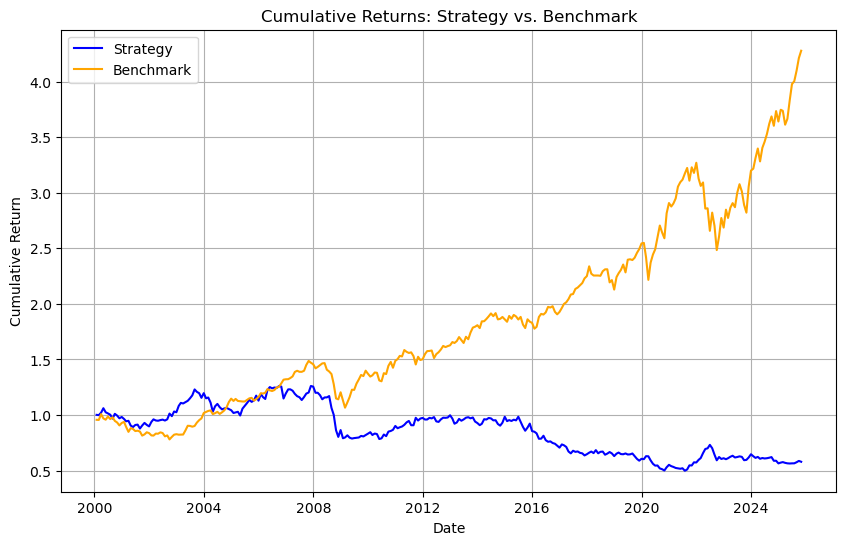

In [39]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()